# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `df_copy` is a copy of the original dataframe `df` and is used only at the start of the data cleaning process in Question 1.
- `df` used from Question 3 onwards is a new dataframe created by using a cleaned .csv file that is created at the end of Question 2. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime
import folium
from folium.plugins import HeatMap
import warnings
import os
import builtins
warnings.filterwarnings("ignore")

Reading in the .csv and creating a dataframe.

In [ ]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

### Question 1: Data Cleaning

1. There are several outliers in the data. Identify these and give justification for why you can remove them from the analysis. (Hint: look at trip duration, speed, distance, etc).
    1. Initial Exploration: Check for missing values, basic statistics, and unusual data points.
    2. Outlier Detection Using Boxplots:
        - **Trip Duration:** Create a boxplot to visualize the distribution of trip durations. Identify outliers as trips with durations significantly shorter or longer than the typical range, based on the Interquartile Range (IQR) method.
        - **Distance Calculation:** Calculate the trip distance using the Haversine formula, which measures the great-circle distance between the pickup and dropoff locations. Use a boxplot to detect outliers in the trip distance data.
        - **Speed Calculation:** Compute the average speed for each trip using the calculated distance and trip duration. Create a boxplot to identify trips with implausibly high or low speeds, indicating potential data entry errors or anomalies.
    3. Remove Outliers: For each of the three variables (trip duration, distance, and speed), remove data points identified as outliers using the IQR method. Outliers are defined as values outside the range of `(Q1 - 1.5 x IQR)` and `(Q3 + 1.5 x IQR)` are the first and third quartiles, respectively.

Initial Exploration: Check for missing values, basic statistics, and unusual data points.

In [ ]:
display(df_copy.info())
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_copy.describe())

In [ ]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Trip Duration Outlier Detection

In [ ]:
# Convert the trip duration to minutes
df_copy['trip_duration_min'] = df_copy['trip_duration'] / 60
display(df_copy[['trip_duration', 'trip_duration_min']].head())

In [ ]:
# Plot the trip duration to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.set_style('whitegrid')
sns.boxplot(
    x=df_copy["trip_duration_min"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Duration (minutes)')
plt.title('Boxplot of Trip Duration')
plt.savefig('./Plots/Plots[1]/trip_duration_boxplot.png')
plt.show()
plt.clf()

In [ ]:
# Define thresholds based on boxplot (IQR method)
Q1_duration = df_copy['trip_duration_min'].quantile(0.25)
Q3_duration = df_copy['trip_duration_min'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Outliers are typically defined as points beyond 1.5 times the IQR
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

print(f'Q1_duration: {Q1_duration}')
print(f'Q3_duration: {Q3_duration}')
print(f'IQR_duration: {IQR_duration}')
print(f'Lower bound: {lower_bound_duration}')
print(f'Upper bound: {upper_bound_duration}')

# Number of entries before cleaning
original_count = len(df_copy)

# Remove outliers for trip duration
df_cleaned = df_copy.copy()
lower_trip_duration_min_index = df_copy[(df_copy['trip_duration_min'] < lower_bound_duration)].index
df_cleaned.drop(lower_trip_duration_min_index, inplace = True)
upper_trip_duration_min_index = df_copy[(df_copy['trip_duration_min'] > upper_bound_duration)].index
df_cleaned.drop(upper_trip_duration_min_index, inplace = True)
#(df_copy['trip_duration_min'] < upper_bound_duration)
# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Trip Distance Outlier Detection

In [ ]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = builtins.map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])

display(df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

In [ ]:
# Plot the trip distance to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["trip_distance_km"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Distance (km)')
plt.title('Boxplot of Trip Distance')
plt.savefig('./Plots/Plots[1]/trip_distance_boxplot.png')
plt.show()
plt.clf()

In [ ]:
# Define thresholds based on boxplot (IQR method)
Q1_distance = df_cleaned['trip_distance_km'].quantile(0.25)
Q3_distance = df_cleaned['trip_distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance

lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance

print(f'Q1_distance: {Q1_distance}')
print(f'Q3_distance: {Q3_distance}')
print(f'IQR_distance: {IQR_distance}')
print(f'Lower bound: {lower_bound_distance}')
print(f'Upper bound: {upper_bound_distance}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip distance
df_cleaned = df_cleaned[(df_cleaned['trip_distance_km'] > lower_bound_distance) | (df_cleaned['trip_distance_km'] < upper_bound_distance)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Trip Speed Outlier Detection

In [ ]:
df_cleaned['speed_kmh'] = df_cleaned['trip_distance_km'] / (df_cleaned['trip_duration'] / 3600)
display(df_cleaned[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

In [ ]:
# Plot the trip speed to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["speed_kmh"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [ ]:
# Define thresholds based on boxplot (IQR method)
Q1_speed = df_cleaned['speed_kmh'].quantile(0.25)
Q3_speed = df_cleaned['speed_kmh'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed

lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

print(f'Q1_speed: {Q1_speed}')
print(f'Q3_speed: {Q3_speed}')
print(f'IQR_speed: {IQR_speed}')
print(f'Lower bound: {lower_bound_speed}')
print(f'Upper bound: {upper_bound_speed}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip speed
df_cleaned = df_cleaned[(df_cleaned['speed_kmh'] > lower_bound_speed) | (df_cleaned['speed_kmh'] < upper_bound_speed)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

In [ ]:
# Final cleaned dataset
print("Shape of cleaned dataset: ", df_cleaned.shape)
display(df_cleaned.head())

**Outlier Identification and Justification for Removal**

**1. Trip Duration Outliers**

- **Analysis**: 
  - The first and third quartiles (Q1 and Q3) of trip duration are approximately 6.62 minutes and 17.92 minutes, respectively, resulting in an Interquartile Range (IQR) of 11.3 minutes.
  - Outliers were identified as trips with durations below the lower bound of -10.33 minutes or above the upper bound of 34.87 minutes. Since negative durations are not possible, only the upper bound was considered.
  - **Results**: After applying this threshold, 74,220 entries were removed, reducing the dataset from 1,458,644 to 1,384,424 entries.

- **Justification for Removal**:
  - **Extreme durations**: Trips with durations significantly longer than the upper bound may result from data entry errors, traffic anomalies, or scenarios where the taxi meter was left running unintentionally. These extreme cases do not represent typical taxi trips and could distort the analysis of average trip times and patterns.

**2. Trip Distance Outliers**

- **Analysis**:
  - The IQR for trip distance was calculated as 2.29 km, with Q1 at 1.20 km and Q3 at 3.48 km. The lower bound was -2.23 km (which is not physically possible) and the upper bound was 6.91 km.
  - **Results**: Applying this threshold removed 107,692 entries, reducing the dataset further to 1,276,732 entries.

- **Justification for Removal**:
  - **Improbable distances**: Trips with distances far exceeding the upper bound may indicate unusually long journeys, possibly due to outliers in pickup/dropoff coordinates or GPS errors. These outliers could mislead any spatial analysis or skew results concerning the typical distance traveled in NYC.

**3. Speed Outliers**

- **Analysis**:
  - For speed, the IQR was 7.49 km/h, with Q1 at 8.78 km/h and Q3 at 16.28 km/h, leading to a lower bound of -2.46 km/h (impossible for real trips) and an upper bound of 27.52 km/h.
  - **Results**: This step removed 39,912 entries, leaving a final dataset of 1,236,820 entries.

- **Justification for Removal**:
  - **Unrealistic speeds**: Extremely high speeds may occur due to incorrect time or distance calculations, possibly indicating data errors or misrecorded trips. Similarly, very low speeds could result from trips that involved significant waiting time, or errors where the vehicle might not have moved but the trip was recorded. Removing these ensures that the analysis focuses on realistic driving conditions, leading to more accurate insights into traffic patterns and trip efficiency.

**Summary**

Outliers across trip duration, distance, and speed were systematically identified using boxplots and the IQR method. Removing these outliers is essential to maintain data integrity, representativeness, and statistical robustness in the analysis. The process ensures that the dataset accurately reflects typical taxi trips in NYC, enabling more reliable and meaningful conclusions from subsequent analyses.

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [ ]:
display(df_cleaned[['trip_distance_km', 'speed_kmh']])

In [ ]:
# Extract day of the week

# Convert pickup and dropoff datetime columns to datetime objects
df_cleaned['pickup_datetime'] = pd.to_datetime(df_cleaned['pickup_datetime'])
df_cleaned['dropoff_datetime'] = pd.to_datetime(df_cleaned['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df_cleaned['day_of_week_str'] = df_cleaned['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df_cleaned['pickup_hour'] = df_cleaned['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['time_of_day'] = df_cleaned['pickup_hour'].apply(time_of_day)

# All new features
display(df_cleaned[['trip_distance_km', 'speed_kmh', 'day_of_week', 'day_of_week_str', 'pickup_hour', 'time_of_day']].head())

# Save the cleaned and feature-enhanced DataFrame for further analysis
df_cleaned.to_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv', index=False)

### Question 3: Time-based

**[3.1]** Which day of the week is the most popular? Show plots to motivate your answer.

In [ ]:
# Read the cleaned dataset
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv')

day_of_week_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x=days, y=day_of_week_counts, hue=days, dodge=False, estimator="sum", palette='viridis')

# Add the total above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of the Week')
plt.savefig('./Plots/Plots[3]/Plots[3.1]/num_of_trips_per_day_of_the_week.png')
plt.show()
plt.clf()

Friday is the most popular day of the week.

**[3.2]** What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

In [ ]:
import os

# Define the folder to save the plots
output_folder = './Plots/Plots[3]/Plots[3.2]'
os.makedirs(output_folder, exist_ok=True)

# Define the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Overall distribution of trips by hour and day of the week
plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='pickup_hour', hue='day_of_week', palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of the Day and Day of the Week')
plt.legend(title='Day of Week', labels=days)
plt.savefig(os.path.join(output_folder, 'trips_by_hour_of_the_day_and_day_of_the_week.png'))
plt.show()
plt.clf()

# Print the most popular hour overall
most_popular_hour_overall = df['pickup_hour'].mode()[0]
print(f'The most popular hour overall is: {most_popular_hour_overall}')

# Individual plots for each day of the week
for i, day in enumerate(days):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df[df['day_of_week'] == i], x='pickup_hour', hue='pickup_hour', palette='viridis', legend=False)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Distribution of Trips by Hour on {day}')
    plt.savefig(os.path.join(output_folder, f'trips_by_hour_on_{day.lower()}.png'))
    plt.show()
    plt.clf()
    
    # Print the most popular hour for each day
    most_popular_hour = df[df['day_of_week'] == i]['pickup_hour'].mode()[0]
    print(f'The most popular hour on {day} is: {most_popular_hour}')

**[3.3]** Investigate the differences between weekdays and weekends. What would account for this? 

In [ ]:
# Create a new column indicating whether the day is a weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Compare trips on weekdays vs weekends
weekend_vs_weekday_counts = df['is_weekend'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_vs_weekday_counts, hue=['Weekday', 'Weekend'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Weekdays vs Weekends')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/num_trips_on_weekdays_vs_weekends.png')
plt.show()
plt.clf()

The bar plot visualizes the number of trips on weekdays compared to weekends. The data shows that significantly more trips occur on weekdays than on weekends. There are several factors that could account for this difference:

1. **Work and School Commutes**:
   - Weekdays typically have higher trip volumes because of regular work and school commutes. People travel to and from work, school, and other routine activities, contributing to the increased number of trips.

2. **Business Activity**:
   - Many businesses operate primarily during weekdays, which results in more trips for meetings, deliveries, and other business-related activities. This could explain the higher trip count on weekdays.

3. **Leisure vs. Routine Travel**:
   - Weekends are generally reserved for leisure activities, which may not require as many short or frequent trips as weekdays. Additionally, many people prefer to stay home or engage in fewer activities during weekends, reducing the overall demand for transportation.

4. **Public Transportation and Ride-Hailing Services**:
   - The availability and demand for public transportation and ride-hailing services might also differ between weekdays and weekends. On weekdays, people might rely more on these services to get to work or school, whereas on weekends, they may opt for alternative transportation or stay in, reducing trip numbers.

**[3.4]** Look at how these patterns change on the major holidays (do they change?). Look at the following: St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, Martin Luther King Day. Make sure you use the correct dates for these for the relevant year.

Steps/Explanation for [3.4] Analysis of Trip Patterns on Major Holidays

Objective: Analyze how trip patterns change on major holidays compared to regular days. The holidays of interest are St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, and Martin Luther King Day in 2016. Specifically, we want to determine if there are significant differences in the hourly distribution of trips and cumulative trip patterns on these holidays.

1. Identify Major Holidays in the Dataset:
    - We first define the dates of the major holidays in 2016 and convert these dates to datetime objects.
The dataset is then processed to include a new column, is_holiday, which indicates whether a trip occurred on a major holiday.

2. Overall Comparison of Trip Counts:
    - A bar plot is created to compare the total number of trips on holidays versus non-holidays. This provides an initial overview of how trip volumes differ on these special days.

3. Hourly Distribution of Trips on Each Holiday:
    - For each holiday, we plot the hourly distribution of trips. This allows us to visualize how trip activity varies throughout the day on each holiday.
    - We compare this distribution with regular days of the same weekday (e.g., compare Martin Luther King Day with other Mondays) to determine whether the holiday significantly alters travel behavior.
    - Additionally, we ensure that the comparison day (one week before the holiday) is not another major holiday to maintain a fair comparison.

4. Cumulative Distribution Function (CDF) Analysis:
    - We plot the Cumulative Distribution Function (CDF) for trips on each holiday and compare it with the CDF for trips on a regular day one week before the holiday. The CDF shows how trips accumulate over the course of the day, highlighting whether trips are more concentrated in the morning, afternoon, or evening on holidays versus regular days.
    - This analysis is crucial for understanding whether travel patterns are more spread out or clustered at certain times during holidays compared to typical weekdays or weekends.

Conclusion:
- This multi-faceted approach provides a comprehensive analysis of how trip patterns change on major holidays. By comparing hourly distributions and cumulative distributions, we gain valuable insights into whether holidays significantly affect travel behavior in New York City. These insights could be useful for understanding traffic management, service demand, and urban planning during holidays.


In [ ]:

output_folder = "./Plots/Plots[3]/Plots[3.4]"

# Define major holidays in 2016
holidays_2016 = {
    'St. Patrick\'s Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    'Valentine\'s Day': '2016-02-14',
    'Martin Luther King Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays_2016.values()))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Create a new column indicating whether the trip occurred on a major holiday
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holiday_dates)

# Compare trip counts on holidays vs non-holidays
holiday_vs_nonholiday_counts = df['is_holiday'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_vs_nonholiday_counts, hue=['Non-Holiday', 'Holiday'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Holidays vs Non-Holidays')
# Save the figure
plt.savefig(os.path.join(output_folder, "trips_holidays_vs_nonholidays.png"))
plt.show()

# Analyze differences during holidays
for holiday, date in holidays_2016.items():
    holiday_data = df[df['pickup_datetime'].dt.date == pd.to_datetime(date).date()]
    
    # Calculate the date exactly one week before
    one_week_before_date = pd.to_datetime(date) - pd.Timedelta(weeks=1)
    
    # Ensure the date one week before is not a major holiday
    while one_week_before_date in holiday_dates:
        one_week_before_date -= pd.Timedelta(weeks=1)
    
    one_week_before_data = df[df['pickup_datetime'].dt.date == one_week_before_date.date()]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=holiday_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='viridis')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on {holiday}')
    plt.savefig(os.path.join(output_folder, f"{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Compare to the date exactly one week before
    plt.figure(figsize=(10, 6))
    sns.countplot(data=one_week_before_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='magma')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on the same weekday one week before {holiday}')
    plt.savefig(os.path.join(output_folder, f"one_week_before_{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Step 6: Cumulative distribution function (CDF)
    combined_data = pd.concat([holiday_data.assign(DayType=holiday), one_week_before_data.assign(DayType='Regular Day one week before')])

    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=combined_data, x='pickup_hour', hue='DayType', palette='Set1')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Cumulative Distribution of Trips on {holiday} vs. one week before')
    plt.savefig(os.path.join(output_folder, f"cdf_{holiday.replace(' ', '_').lower()}_vs_one_week_before.png"))
    plt.show()

    plt.clf()

# Holiday vs. Non-Holiday Cumulative Distribution
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='pickup_hour', hue='is_holiday', palette='mako')
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trips on Holidays vs Non-Holidays')
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'])
plt.savefig(os.path.join(output_folder, "cdf_holidays_vs_nonholidays.png"))
plt.show()

**Analyzing the Differences Between Holiday and Non-Holiday Trip Patterns**

Based on the CDF plots, we can observe several key differences in trip patterns between holidays and non-holidays:

1. **Delayed Starts:** The CDF for holidays consistently starts lower than the CDF for non-holidays, indicating fewer trips in the early hours on holidays. This suggests a delayed start to the day compared to regular days.
2. **Extended Evening Hours:** The CDF for holidays consistently ends higher than the CDF for non-holidays, indicating a higher proportion of trips occurring later in the evening on holidays. This suggests extended activities or a different pattern of evening travel.
3. **Mid-Day Similarity:** While the early and late hours show significant differences, the lines for holidays and non-holidays tend to converge around the mid-day and afternoon hours. This suggests that trip patterns during these times are relatively similar, with less variation between holidays and non-holidays.

**Overall, the analysis indicates that while the general pattern of trip accumulation over the day is similar for holidays and non-holidays, there are notable differences in the timing of trips.** Holidays are characterized by delayed starts and extended evening hours, suggesting that social and leisure activities play a significant role in shaping travel behavior on these days.

**[3.5]** How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

**Steps:**
- Calculate Average Speed per Hour: Group the data by the hour of the day and calculate the mean speed for each hour.
- Plot the Average Speed: Create a line plot to visualize how average speed changes throughout the day.
- Identify the Fastest Time of Day: Highlight the hour(s) where the average speed is the highest.

In [ ]:
# Calculate the average speed per hour
avg_speed_per_hour = df.groupby('pickup_hour')['speed_kmh'].mean()

# Step 2: Plot the average speed throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_per_hour.index, y=avg_speed_per_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed of Trips Throughout the Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on the x-axis
plt.grid(True)

# Highlight the hour(s) with the highest average speed
fastest_hour = avg_speed_per_hour.idxmax()
fastest_speed = avg_speed_per_hour.max()
plt.axvline(x=fastest_hour, color='red', linestyle='--', label=f'Fastest Hour: {fastest_hour}h, {fastest_speed:.2f} km/h')
plt.legend()

plt.savefig('./Plots/Plots[3]/Plots[3.5]/average_speed_throughout_day.png')

plt.show()
plt.clf()

print(f"The fastest time of day is around {fastest_hour}:00 with an average speed of {fastest_speed:.2f} km/h.")


### Question 4: Location clusters
**[4.1]** Heatmaps

Produce a heatmap of all of the trip pickups over (do not do a scatter plot... there are 1.5 million data points and this will almost certainly crash your computer):
1. weekdays and weekends,
2. morning and evening (choose reasonable hours).

Comment on any findings you make.

In [ ]:
df['week_part'] = df['day_of_week_str'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

week_part_counts = df['week_part'].value_counts().reindex(['Weekday', 'Weekend']).fillna(0).reset_index()
week_part_counts.columns = ['week_part', 'count']
heatmap_data = week_part_counts.set_index('week_part').T

#plot heatmap for weekdays vs weekends
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Spectral", cbar=False)
plt.title('Heatmap of Trip Pickups: Weekdays vs. Weekends')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_weekdays_vs_weekends.png')
plt.show()

time_of_day_counts = df['time_of_day'].value_counts().reindex(['Morning', 'Evening']).fillna(0).reset_index()
time_of_day_counts.columns = ['time_of_day', 'count']
heatmap_data = time_of_day_counts.set_index('time_of_day').T

#plot heatmap for morning vs evening
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Spectral", cbar=False)
plt.title('Heatmap of Trip Pickups: Morning vs. Evening')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_morning_vs_evening.png')
plt.show()

1. The heatmap data reveals that weekdays have significantly more total pickups (886259) compared to weekends (350661), reflecting higher weekday travel due to work-related activities. However, the weekend's total is distributed over just 2 days compared to 5 weekdays, resulting in similar average daily pickup counts: approximately 177252 on weekdays and 175331 on weekends. This indicates that while weekdays have a higher cumulative total, the demand on weekends is nearly as high on a daily basis.
2. Morning pickups slightly surpass evening pickups, with 316807 trips occurring in the morning and 300230 in the evening. Despite mornings covering a broader time range (7 hours) compared to evenings (4 hours), the relatively close totals suggest a high level of demand throughout both periods. This suggests that both morning and evening times are critical for transportation services, with significant activity during these peak hours.

In [ ]:
df['week_part'] = df['day_of_week_str'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
planning_data = df[df['time_of_day'].isin(['Morning', 'Evening'])]

#pivot table to count pickups
pivot_table = planning_data.pivot_table(index='week_part', columns='time_of_day', aggfunc='size', fill_value=0)

#plot heatmap of weekdays, weekends, mornings and evenings
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Spectral")
plt.title('Heatmap of Trip Pickups by Weekday/Weekend and Morning/Evening')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_of_all.png')
plt.show()

 Weekday pickups are higher in the morning (253766) compared to the evening (222012), reflecting typical workday commuting patterns. Conversely, weekend pickups are more frequent in the evening (78218) than in the morning (63041), aligning with common social and recreational activities that peak during weekends. This trend highlights that weekdays have higher overall trip volumes due to regular work routines, while weekends see a shift towards more evening trips. 

**[4.2]** Hotspots

If you were a taxi driver wanting to plan your evenings so that you could get the most trips, you would want to know where the popular areas are. Looking at the time periods 23:00 on a Friday evening to 02:00 on a Saturday morning, and between 17:00 and 20:00 on a Thursday, find hotspot locations (areas where there are a large number of trips happening). If you were to use k-means, you would define the number of clusters. However, here the number of clusters is not at all clear. DBSCAN (available in sklearn) determines this for you, and works well on spatial data. DBSCAN has two configurable parameters: ε-the maximum distance between any two points, and the minimum number of samples to determine a cluster. Your hotspot location might be defined as at least 15 pickups in that location in an hour, and locations might be required to be within 50 or 100 metres from each other (motivate your choice of parameters). Using DBSCAN, identify clusters and plot these on a map. How many clusters did you find? 

In [ ]:
friday_evening = df[(df['pickup_datetime'].dt.dayofweek == 4) & 
                      (df['pickup_datetime'].dt.hour >= 23) | 
                      (df['pickup_datetime'].dt.dayofweek == 5) & 
                      (df['pickup_datetime'].dt.hour < 2)]

thursday_evening = df[(df['pickup_datetime'].dt.dayofweek == 3) & 
                        (df['pickup_datetime'].dt.hour >= 17) & 
                        (df['pickup_datetime'].dt.hour < 20)]

planning_data = pd.concat([friday_evening, thursday_evening])
coords = planning_data[['pickup_latitude', 'pickup_longitude']].values

max_distance = 0.1  #0.1 because thats 100m in km
min_cars = 15
kms_per_radian = 6371.0088
epsilon = max_distance / kms_per_radian
#apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_cars, algorithm='ball_tree', metric='haversine')
clusters = db.fit_predict(np.radians(coords))

#add the cluster labels back to the dataframe
planning_data['cluster'] = clusters

#number of clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {n_clusters}")

# Plot the clusters on a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(planning_data['pickup_longitude'], planning_data['pickup_latitude'], c=planning_data['cluster'], cmap='rainbow', s=10)
plt.title(f"Hotspot Locations - {n_clusters} clusters")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.savefig('./Plots/Plots[4]/Plots[4.2]/clusters_scatter_plot.png')
plt.show()

#coordinates of New York City
nyc_lat, nyc_lon = 40.7128, -74.0060
cluster_map = folium.Map(location=[nyc_lat, nyc_lon], tiles="CartoDB Positron", zoom_start=11)
colormap = plt.colormaps.get_cmap('tab20')
#add DBSCAN clusters to the map
for lat, lon, cluster in zip(planning_data['pickup_latitude'], planning_data['pickup_longitude'], planning_data['cluster']):
    if cluster != -1:
        color = colormap(cluster % colormap.N)  # Normalize to 0-1 range for color mapping
        color = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'  # Convert to hex
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(cluster_map)
cluster_map.save('nyc_cluster_map.html')
cluster_map

In [ ]:
from folium import plugins

heat_data = [[row['pickup_latitude'], row['pickup_longitude']] for index, row in planning_data.iterrows()]
heatmap = folium.Map(location=[nyc_lat, nyc_lon], zoom_start=10, tiles='Cartodb dark_matter')
plugins.HeatMap(heat_data).add_to(heatmap)
heatmap.save('nyc_heatmap.html')
heatmap

### Question 5: Airports

Find out how long it takes, on average, to travel to JFK airport from the Empire State Building. Produce a plot showing the travel time by time of day. How does this compare with Newark Airport? Assume the following coordinates for the centre point of the locations (long, lat):

- JFK Airport: (40.647929, -73.777813)
- Empire State Building: (40.756724, -73.983806)
- Newark Airport: (40.689442, -74.173242)

Use a reasonable (and motivate!) radius around these locations when determining if a GPS coordinate is at that location. [9 marks]

To do / plan:

- how long it takes to get to JFK from Empire State Building.
- pick a revelent radius for the airports and building
- calculate travel times
- separate/ organise by time of the day.
- plot graph, histogram?

travel time:  trip_duration_min
locations:
    start: pickup_longitude and pickup_latitude
    end: dropoff_longitude and dropoff_latitude

- new dataframe that has:
    - only data from relevant trips ( ie the airport trips)
    - travel times
    - time of day of the trips

#### Explanations / Answers Q5

JFK:
- On average it takes 49.48 mintues to get to JFK airport from the Empire State Building.
- It takes the longest to get to JFK from the Empire State building in the afternoon and the shortest at night.

Newark:
- On average it takes 36.33 minutes to get to Newark airport from the Empire State Building.
- It takes the longest to get to Newark from the Empire State Building in the evening and the shortest at night.

On average it takes longer to get to JFK airport than it takes to get to Newark airport from the Empire State building. At any time of day it takes longer to get to JFK airport than it does to get to Newark Airport. The general trends of the trip durations at the different times of days is the same for both airports, with the only slight diffference being that the longest duration trip is in the afternoon for JFK and in the evening for Newark. The second longest trip durations are in the evening and afternoon for JFK airport and Newark airport respectively. The shortest for both is at night and the second shorted is in the morning for both as well.

The haversine function was used to fine the distances between the pickup and dropoff locations and the Empire State Building and airports respectively. These distances were checked if they were smaller than the defined radius to determine if the pickup and dropoff points were located at the Empire State building and the airports. The pandas dataframe was modified to only contain the trips from the Empire State Building to the different airports. The average of the different trip durations was calculated for each time of day.

Radius motivation:
We decided to have 3 different radius values for the 3 different locations. The coordinates of the different locations is the coordinates of the center of the location. Therefore, it would be unfair to use the same radius for the Empire State building and for JFK airport as these  2 locations are vastly different in size.

The radius values for the 3 different locations was determined by looking at the area that the location takes up and the context of the location.

The radius value for the Empire state building was decided to be 500m. This is beacuse the Empire State Buiding does not take up that much area on thr ground. The Empire State Building is also in the dense city, meaning having a radius that is too big will result in incorrectly classifying pickup locations that are not specifically at the Empire State building to be at the Empire State Building. We did try different values for this radius, for example we tries 100 meters but found that this would result in there being too little trips included in order to accurately assess the travel durations for the trips to the airport.

The radius values for the airports was determined by googling the surface area of the different airports. we used this surface area as the approximate circular area of the airports. A caluclation was done to determine the radius of a circle with this area.

- The area of JFK airport is 21.04km^2. The radius of a circle that has the area of 21.04km^2 is 2.588km.
- The area of Newark airport is 8.20 km^2. The radius of a circle that has the area of 8.20 km^2 is 1.6156 km.

Therfore we decided to make the radius of the JFK airport 3.5 km and the radius of Newark airport 2.5 km. This is about 1km greater than the approximate circular radius, and this is to account for ubers/taxis not dropping off customers directly at the airport perimeter. This increase opf the radius is to help increase the amount of datapoints available in order to accurately calculate the average duration of the trips, as explained above with the Empire State Building radius. The radius for the airports can also be increased more as the aiports will be in a more open area of New York, meaning that dropoff points will be less likley to be misclassified as the arirports.

In [ ]:
# Read the cleaned dataset
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_new_features_v2.csv')
display(df)

In [ ]:
airport_trips_traveltimes_df = df.copy()
not_relevant_columns = airport_trips_traveltimes_df.columns.to_list()
not_relevant_columns.remove("pickup_longitude")
not_relevant_columns.remove("pickup_latitude")
not_relevant_columns.remove("dropoff_longitude")
not_relevant_columns.remove("dropoff_latitude")
not_relevant_columns.remove("trip_duration_min")
not_relevant_columns.remove("time_of_day")
not_relevant_columns.remove("pickup_hour")
airport_trips_traveltimes_df.drop(not_relevant_columns, axis=1, inplace=True)

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = builtins.map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# JFK = JFK Airport
# ESB = Empire State Building
# Newark = Newark Airport

JFK_LAT =  40.647929
JFK_LONG =  -73.777813

ESB_LAT =  40.756724
ESB_LONG = -73.983806

NEWARK_LAT = 40.689442
NEWARK_LONG = -74.173242

radius_esb = 0.5 
radius_jfk = 3.5
radius_newark = 2.5

        
def pickupLocation(row):
    pickup_long = row['pickup_longitude']
    pickup_lat =  row['pickup_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, pickup_long, pickup_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, pickup_long, pickup_lat) <= radius_jfk:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, pickup_long, pickup_lat) <= radius_newark:
        return "Newark"
    else:
        return "NA"
    
def dropoffLocation(row):
    dropoff_long = row['dropoff_longitude']
    dropoff_lat = row['dropoff_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, dropoff_long, dropoff_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, dropoff_long, dropoff_lat) <= radius_jfk:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, dropoff_long, dropoff_lat) <= radius_newark:
        return "Newark"
    else:
        return "NA"


airport_trips_traveltimes_df['pickup_location'] = ""
airport_trips_traveltimes_df['dropoff_location'] = ""

airport_trips_traveltimes_df['pickup_location'] = airport_trips_traveltimes_df.apply(pickupLocation, axis = 1)
airport_trips_traveltimes_df['dropoff_location'] = airport_trips_traveltimes_df.apply(dropoffLocation, axis = 1)

airport_trips_traveltimes_df = airport_trips_traveltimes_df[(airport_trips_traveltimes_df['pickup_location'] == "ESB") & ((airport_trips_traveltimes_df['dropoff_location'] == "JFK") |(airport_trips_traveltimes_df['dropoff_location'] == "Newark")) ]

display(airport_trips_traveltimes_df)

In [ ]:
esb_jfk_trip = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration = esb_jfk_trip['trip_duration_min']
esb_jfk_trip_duration_average = esb_jfk_trip_duration.mean()
print("Average time to get from Empire State Building to JFK Airport: "+str(esb_jfk_trip_duration_average))

In [ ]:
esb_newark_trip = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration = esb_newark_trip['trip_duration_min']
esb_newark_trip_duration_average = esb_newark_trip_duration.mean()
print("Average time to get from Empire State Building to Newark Airport: "+str(esb_newark_trip_duration_average))

In [ ]:
# get average trip durtion per time of day

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_afternoon = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Afternoon"]['trip_duration_min']
esb_newark_trip_duration_afternoon_average = esb_newark_trip_duration_afternoon.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_afternoon = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Afternoon"]['trip_duration_min']
esb_jfk_trip_duration_afternoon_average = esb_jfk_trip_duration_afternoon.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_evening = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Evening"]['trip_duration_min']
esb_newark_trip_duration_evening_average = esb_newark_trip_duration_evening.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_evening = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Evening"]['trip_duration_min']
esb_jfk_trip_duration_evening_average = esb_jfk_trip_duration_evening.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_morning = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Morning"]['trip_duration_min']
esb_newark_trip_duration_morning_average = esb_newark_trip_duration_morning.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_morning = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Morning"]['trip_duration_min']
esb_jfk_trip_duration_morning_average = esb_jfk_trip_duration_morning.mean()

esb_newark_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"]
esb_newark_trip_duration_night = esb_newark_trip_duration[esb_newark_trip_duration['time_of_day'] == "Night"]['trip_duration_min']
esb_newark_trip_duration_night_average = esb_newark_trip_duration_night.mean()

esb_jfk_trip_duration = airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"]
esb_jfk_trip_duration_night = esb_jfk_trip_duration[esb_jfk_trip_duration['time_of_day'] == "Night"]['trip_duration_min']
esb_jfk_trip_duration_night_average = esb_jfk_trip_duration_night.mean()



print("ESB to Newark in Afternoon: " + str(esb_newark_trip_duration_afternoon_average))
print("ESB to JFK in Afternoon: " + str(esb_jfk_trip_duration_afternoon_average))
print("ESB to Newark in Evening: " + str(esb_newark_trip_duration_evening_average))
print("ESB to JFK in Evening: " + str(esb_jfk_trip_duration_evening_average))
print("ESB to Newark in Morning: " + str(esb_newark_trip_duration_morning_average))
print("ESB to JFK in Morning: " + str(esb_jfk_trip_duration_morning_average))
print("ESB to Newark at night: " + str(esb_newark_trip_duration_night_average))
print("ESB to JFK at night: " + str(esb_jfk_trip_duration_night_average))

trip_duration_averages_jfk = {"Morning": esb_jfk_trip_duration_morning_average,"Afternoon": esb_jfk_trip_duration_afternoon_average,"Evening": esb_jfk_trip_duration_evening_average, "Night": esb_jfk_trip_duration_night_average}
trip_duration_jfk = {"Morning": esb_jfk_trip_duration_morning,"Afternoon": esb_jfk_trip_duration_afternoon,"Evening": esb_jfk_trip_duration_evening, "Night": esb_jfk_trip_duration_night}

trip_duration_averages_newark = {"Morning": esb_newark_trip_duration_morning_average,"Afternoon": esb_newark_trip_duration_afternoon_average,"Evening": esb_newark_trip_duration_evening_average, "Night": esb_newark_trip_duration_night_average}
trip_duration_newark = {"Morning": esb_newark_trip_duration_morning,"Afternoon": esb_newark_trip_duration_afternoon,"Evening": esb_newark_trip_duration_evening, "Night": esb_newark_trip_duration_night}

In [ ]:
plt.figure(figsize=(16, 10))
sns.barplot(trip_duration_jfk, palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration')
plt.title('Distribution of Average Duration of Trips from Empire State Building to JFK Airport per Time of Day')
plt.savefig( './Plots/Plots[5]/trip_duration_ESB_to_JFK_per_time_of_day.png')
plt.show()
plt.clf()

plt.figure(figsize=(16, 10))
sns.barplot(trip_duration_newark, palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration')
plt.title('Distribution of Average Duration of Trips from Empire State Building to Newark Airport per Time of Day')
plt.savefig('./Plots/Plots[5]/trip_duration_ESB_to_Newark_per_time_of_day.png')
plt.show()
plt.clf()

plt.figure(figsize=(16, 10))
sns.barplot(data=airport_trips_traveltimes_df, x='time_of_day', y='trip_duration_min', hue='dropoff_location', palette='viridis')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Duration')
plt.title('Distribution of Average Trip Duration to Airports from Empire State Building per Time of Day')
plt.savefig('./Plots/Plots[5]/trip_duration_from_ESB_both_airports_per_time_of_day.png')
plt.show()
plt.clf()


In [ ]:
plt.figure(figsize=(16, 10))
palette = sns.color_palette("husl", 2)
sns.lineplot(data=airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "JFK"], x='pickup_hour', y='trip_duration_min', label='JFK', color=palette[0])
sns.lineplot(data=airport_trips_traveltimes_df[airport_trips_traveltimes_df['dropoff_location'] == "Newark"], x='pickup_hour', y='trip_duration_min', label='Newark', color=palette[1])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Average Trip Duration by Hour of the Day for trips from Empire State Building to the Different Airports')
plt.legend(title='Aiport')
plt.savefig('./Plots/Plots[5]/line_graph_trip_duration_from_ESB_both_airports_hour_of_day.png')
plt.show()
plt.clf()

### Question 6: Boroughs

You can find the shapefile containing NYC boroughs (basically neighbourhoods)
here https://data.cityofnewyork.us/City-Government/2010-Neighborhood-Tabulation-Areas-NTAs-/
cpf4-rkhq. It is also available for download on Moodle.

#### Q6 explanations / answers:

To determine the neighborhoods for the trip start and end locations, we checked whether the pickup and dropoff coordinates (longitude and latitude) fell within the geometries of each neighborhood, based on the shapefile. 

Q2 explanation and answer:

In order to plot the chloropeths, we created 2 new columns in the Geopandas GeoDataFrame of the shape file data to represent the number of pickups and dropoffs for each neighbourhood. 

The chloropleths are unevenly distributed as there are there are only a few neighbourhoods that have a notable number of pickups or dropoffs. Most of the neighbourhoods have around the same number of very few pickups and dropoffs. The neighbourhoods and general area of New York that have the most pickups also have the most dropoffs. The same can be said about the areas with the least amount of dropoffs and pickups. Therefore the trend is similar for the pickups and dropoffs.

There are some areas that ddo not that pickups at all but they do have dropoffs. The dropoffs chloropleth distribution covers a wider range of the different areas of New York compared to the pickups chloropleth.


Q3 answer:



There are alot of neighbourhoods that had only 1 pickup or dropoff, therefore only a sellect few will be included in the list.

The Neighbourhoods that were the quietest at night area:
- Oakland Gardens  
- Madison
- College Point
- Fresh Meadows-Utopia
- Old Town-Dongan Hills-South Beach




Q4 answer:
The neighbourhoods that were the busiest aat night are:
- Midtown-Midtown South
- Hudson Yards-Chelsea-Flatiton-Union Square
- West Village
- East Village
- Clinton
- Chinatown
- SoHo-TribeCa-Civiv Center-Little Italy 



**[6.1]**
Using this shapefile find the neighbourhoods for the trip start and end
locations (try geopandas, shapely, or fiona, for example). [3 marks]

In [37]:
import geopandas
import shapely

gdf = geopandas.read_file("2010 Neighborhood Tabulation Areas (NTAs)/geo_export_01b7a854-00a9-4a17-93fc-4e53946a61f0.shp")
display(gdf)

# Read the cleaned dataset
df_q6 = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_new_features_v2.csv')

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316915,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609937,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
2,2.0,Bronx,005,BX41,Mount Hope,1.471671e+07,18937.248075,"POLYGON ((-73.89561 40.85457, -73.89662 40.852..."
3,4.0,Queens,081,QN38,Pomonok-Flushing Heights-Hillcrest,3.883592e+07,30731.419625,"POLYGON ((-73.7964 40.73828, -73.79639 40.7382..."
4,4.0,Queens,081,QN52,East Flushing,2.945368e+07,25848.545511,"POLYGON ((-73.79493 40.7578, -73.79475 40.7556..."
...,...,...,...,...,...,...,...,...
190,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847700e+07,32542.473318,"POLYGON ((-73.97906 40.70595, -73.97906 40.705..."
191,4.0,Queens,081,QN12,Hammels-Arverne-Edgemere,6.189991e+07,83078.817269,"POLYGON ((-73.7681 40.59785, -73.76795 40.5974..."
192,4.0,Queens,081,QN15,Far Rockaway-Bayswater,5.420674e+07,48666.029209,"POLYGON ((-73.76376 40.59144, -73.76386 40.591..."
193,2.0,Bronx,005,BX75,Crotona Park East,1.631186e+07,24782.286025,"POLYGON ((-73.8736 40.8398, -73.87283 40.83975..."


In [38]:
def findPickupNeighbourhood(row):
    pickup_lat = row['pickup_latitude']
    pickup_long = row['pickup_longitude']
    pickup_point = shapely.Point(pickup_long, pickup_lat)
    #bool_neighbourhoods = gdf['geometry'].contains(pickup_point)
    #gdf.iloc[gdf.sindex.query(pickup_point, predicate = "contains")]
    neighbourhood_series = gdf.iloc[gdf['geometry'].sindex.query(pickup_point, predicate = "within")]['ntaname']
    if neighbourhood_series.empty:
        neighbourhood = 'NA'
    else:
        neighbourhood = neighbourhood_series.iloc[0]
    return neighbourhood

df_q6['pickup_neighbourhood'] = ""
df_q6['pickup_neighbourhood'] = df_q6.apply(findPickupNeighbourhood, axis = 1)

display(df_q6)

def findDropoffNeighbourhood(row):
    dropff_lat = row['dropoff_latitude']
    dropoff_long = row['dropoff_longitude']
    dropoff_point = shapely.Point(dropoff_long, dropff_lat)
    #bool_neighbourhoods = gdf['geometry'].contains(dropoff_point)
    neighbourhood_series = gdf.iloc[gdf['geometry'].sindex.query(dropoff_point, predicate = "within")]['ntaname']
    if neighbourhood_series.empty:
        neighbourhood = 'NA'
    else:
        neighbourhood = neighbourhood_series.iloc[0]
    return neighbourhood

df_q6['dropoff_neighbourhood'] = ""
df_q6['dropoff_neighbourhood'] = df_q6.apply(findDropoffNeighbourhood, axis = 1)

display(df_q6)

# add number of pickups and dropoffs per neighbourhood to the GeoDataframe
pickup_neighboughood_counts = df_q6['pickup_neighbourhood'].value_counts()
gdf['neighbourhood_pickup_counts'] = gdf['ntaname'].map(pickup_neighboughood_counts)

dropoff_neighboughood_counts = df_q6['dropoff_neighbourhood'].value_counts()
gdf['neighbourhood_dropoff_counts'] = gdf['ntaname'].map(dropoff_neighboughood_counts)
display(gdf)

df_q6.to_csv('./nyc_taxis/nyc_taxi_with_neighbourhoods.csv', index=False)
gdf.to_file('./with_neighbourhood_counts.shp')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day,is_weekend,is_holiday,trip_duration_min,pickup_neighbourhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.497580,11.848984,0,Monday,17,Evening,0,False,7.583333,Lincoln Square
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.804374,9.797504,6,Sunday,0,Night,1,False,11.050000,Murray Hill-Kips Bay
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.381090,10.815406,1,Tuesday,11,Morning,0,False,35.400000,Midtown-Midtown South
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.484566,12.457894,2,Wednesday,19,Evening,0,False,7.150000,SoHo-TriBeCa-Civic Center-Little Italy
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.187842,9.830418,5,Saturday,13,Afternoon,1,False,7.250000,Upper West Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447055,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,1.224311,5.665192,4,Friday,13,Afternoon,0,False,12.966667,Murray Hill-Kips Bay
1447056,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,6.046037,33.230128,6,Sunday,7,Morning,1,False,10.916667,Hudson Yards-Chelsea-Flatiron-Union Square
1447057,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,7.819693,36.846722,4,Friday,6,Morning,0,False,12.733333,Lenox Hill-Roosevelt Island
1447058,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,1.091878,10.538232,1,Tuesday,15,Afternoon,0,False,6.216667,Murray Hill-Kips Bay


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day,is_weekend,is_holiday,trip_duration_min,pickup_neighbourhood,dropoff_neighbourhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,11.848984,0,Monday,17,Evening,0,False,7.583333,Lincoln Square,Upper East Side-Carnegie Hill
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,9.797504,6,Sunday,0,Night,1,False,11.050000,Murray Hill-Kips Bay,West Village
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,10.815406,1,Tuesday,11,Morning,0,False,35.400000,Midtown-Midtown South,Battery Park City-Lower Manhattan
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,12.457894,2,Wednesday,19,Evening,0,False,7.150000,SoHo-TriBeCa-Civic Center-Little Italy,Battery Park City-Lower Manhattan
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,9.830418,5,Saturday,13,Afternoon,1,False,7.250000,Upper West Side,Upper West Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447055,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,5.665192,4,Friday,13,Afternoon,0,False,12.966667,Murray Hill-Kips Bay,Hudson Yards-Chelsea-Flatiron-Union Square
1447056,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,33.230128,6,Sunday,7,Morning,1,False,10.916667,Hudson Yards-Chelsea-Flatiron-Union Square,Upper West Side
1447057,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,36.846722,4,Friday,6,Morning,0,False,12.733333,Lenox Hill-Roosevelt Island,Battery Park City-Lower Manhattan
1447058,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,10.538232,1,Tuesday,15,Afternoon,0,False,6.216667,Murray Hill-Kips Bay,Midtown-Midtown South


,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,neighbourhood_pickup_counts,neighbourhood_dropoff_counts
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316915,"POLYGON ((-73.75205 40.70523, -73.75174 40.704...",3.0,153.0
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609937,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",30.0,266.0
2,2.0,Bronx,005,BX41,Mount Hope,1.471671e+07,18937.248075,"POLYGON ((-73.89561 40.85457, -73.89662 40.852...",30.0,261.0
3,4.0,Queens,081,QN38,Pomonok-Flushing Heights-Hillcrest,3.883592e+07,30731.419625,"POLYGON ((-73.7964 40.73828, -73.79639 40.7382...",13.0,217.0
4,4.0,Queens,081,QN52,East Flushing,2.945368e+07,25848.545511,"POLYGON ((-73.79493 40.7578, -73.79475 40.7556...",9.0,92.0
...,...,...,...,...,...,...,...,...,...,...
190,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847700e+07,32542.473318,"POLYGON ((-73.97906 40.70595, -73.97906 40.705...",4569.0,7867.0
191,4.0,Queens,081,QN12,Hammels-Arverne-Edgemere,6.189991e+07,83078.817269,"POLYGON ((-73.7681 40.59785, -73.76795 40.5974...",5.0,50.0
192,4.0,Queens,081,QN15,Far Rockaway-Bayswater,5.420674e+07,48666.029209,"POLYGON ((-73.76376 40.59144, -73.76386 40.591...",2.0,51.0
193,2.0,Bronx,005,BX75,Crotona Park East,1.631186e+07,24782.286025,"POLYGON ((-73.8736 40.8398, -73.87283 40.83975...",9.0,83.0


In [44]:
df_q6.to_csv('./nyc_taxis/nyc_taxi_with_neighbourhoods.csv', index=False)
gdf.to_file('./with_neighbourhood_counts.shp')

**[6.2]**
Plot a chloropeth of all pickups and all dropoffs in NYC. What do you
notice about the difference in distribution? [2 marks]

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,neighbourh,neighbou_1,geometry
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316915,3.0,153.0,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609937,30.0,266.0,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
2,2.0,Bronx,005,BX41,Mount Hope,1.471671e+07,18937.248075,30.0,261.0,"POLYGON ((-73.89561 40.85457, -73.89662 40.852..."
3,4.0,Queens,081,QN38,Pomonok-Flushing Heights-Hillcrest,3.883592e+07,30731.419625,13.0,217.0,"POLYGON ((-73.7964 40.73828, -73.79639 40.7382..."
4,4.0,Queens,081,QN52,East Flushing,2.945368e+07,25848.545511,9.0,92.0,"POLYGON ((-73.79493 40.7578, -73.79475 40.7556..."
...,...,...,...,...,...,...,...,...,...,...
190,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847700e+07,32542.473318,4569.0,7867.0,"POLYGON ((-73.97906 40.70595, -73.97906 40.705..."
191,4.0,Queens,081,QN12,Hammels-Arverne-Edgemere,6.189991e+07,83078.817269,5.0,50.0,"POLYGON ((-73.7681 40.59785, -73.76795 40.5974..."
192,4.0,Queens,081,QN15,Far Rockaway-Bayswater,5.420674e+07,48666.029209,2.0,51.0,"POLYGON ((-73.76376 40.59144, -73.76386 40.591..."
193,2.0,Bronx,005,BX75,Crotona Park East,1.631186e+07,24782.286025,9.0,83.0,"POLYGON ((-73.8736 40.8398, -73.87283 40.83975..."


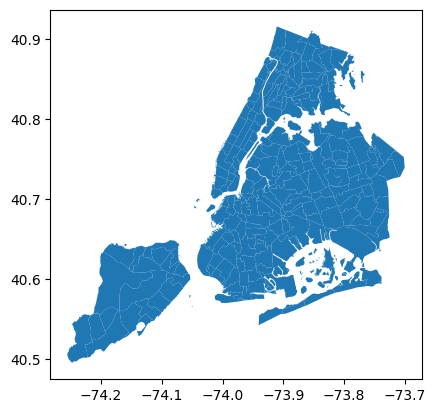

<Figure size 1600x1000 with 0 Axes>

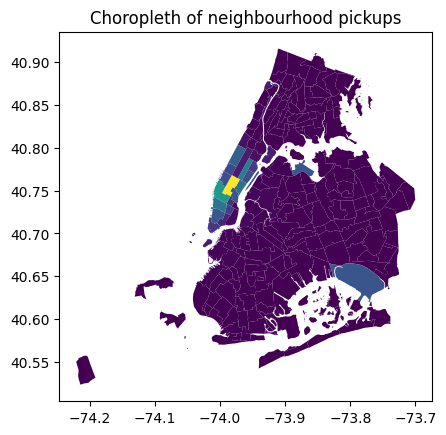

<Figure size 640x480 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

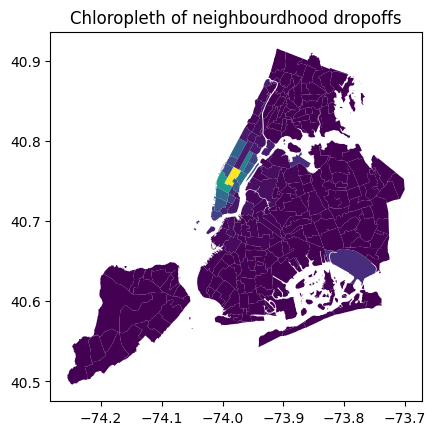

<Figure size 640x480 with 0 Axes>

In [50]:
gdf_new = geopandas.read_file("./with_neighbourhood_counts.shp")

display(gdf_new)

gdf_new.plot()

plt.figure(figsize=(16, 10))
gdf_new.plot(column = "neighbourh")
plt.title('Choropleth of neighbourhood pickups')
plt.savefig('./Plots/Plots[6]/pickups_neighbourhoods_cloropleth.png')
plt.show()
plt.clf()



plt.figure(figsize=(16, 10))
gdf_new.plot(column = "neighbou_1")
plt.title('Chloropleth of neighbourdhood dropoffs')
plt.savefig('./Plots/Plots[6]/dropoffs_neighbourhoods_cloropleth.png')
plt.show()
plt.clf()


**[6.3]**
Which neighbourhood(s) is/are the quietest at night, between midnight
and 5AM? [2 marks]

In [48]:
df_night_neighbourhoods = pd.read_csv('./nyc_taxis/nyc_taxi_with_neighbourhoods.csv')

pickup_neighboughood_counts = df_night_neighbourhoods['pickup_neighbourhood'].value_counts()
dropoff_neighboughood_counts = df_night_neighbourhoods['dropoff_neighbourhood'].value_counts()


midnight_to_5am_trips = df_night_neighbourhoods[(df_night_neighbourhoods['pickup_hour'] > 0) & (df_night_neighbourhoods['pickup_hour'] < 5)]

pickup_night_trips_neighbourhood_counts = midnight_to_5am_trips['pickup_neighbourhood'].value_counts()
pickup_night_trips_neighbourhood_counts = pd.concat([pickup_night_trips_neighbourhood_counts.head(20), pickup_night_trips_neighbourhood_counts.tail(20)])
dropoff_night_trips_neighbourhood_counts = midnight_to_5am_trips['dropoff_neighbourhood'].value_counts()
dropoff_night_trips_neighbourhood_counts = pd.concat([dropoff_night_trips_neighbourhood_counts.head(20), dropoff_night_trips_neighbourhood_counts.tail(20)])

total_activity_night_trips_neighbourhood_counts = pickup_night_trips_neighbourhood_counts.add(dropoff_night_trips_neighbourhood_counts, fill_value=0)
total_activity_night_trips_neighbourhood_counts.sort_values(ascending=False, inplace=True)

display(total_activity_night_trips_neighbourhood_counts.head(5))
display(total_activity_night_trips_neighbourhood_counts.tail(5))

Midtown-Midtown South                         24107.0
Hudson Yards-Chelsea-Flatiron-Union Square    18701.0
West Village                                  18361.0
East Village                                  13695.0
Clinton                                       10541.0
Name: count, dtype: float64

Old Town-Dongan Hills-South Beach    1.0
Fresh Meadows-Utopia                 1.0
College Point                        1.0
Madison                              1.0
Oakland Gardens                      1.0
Name: count, dtype: float64

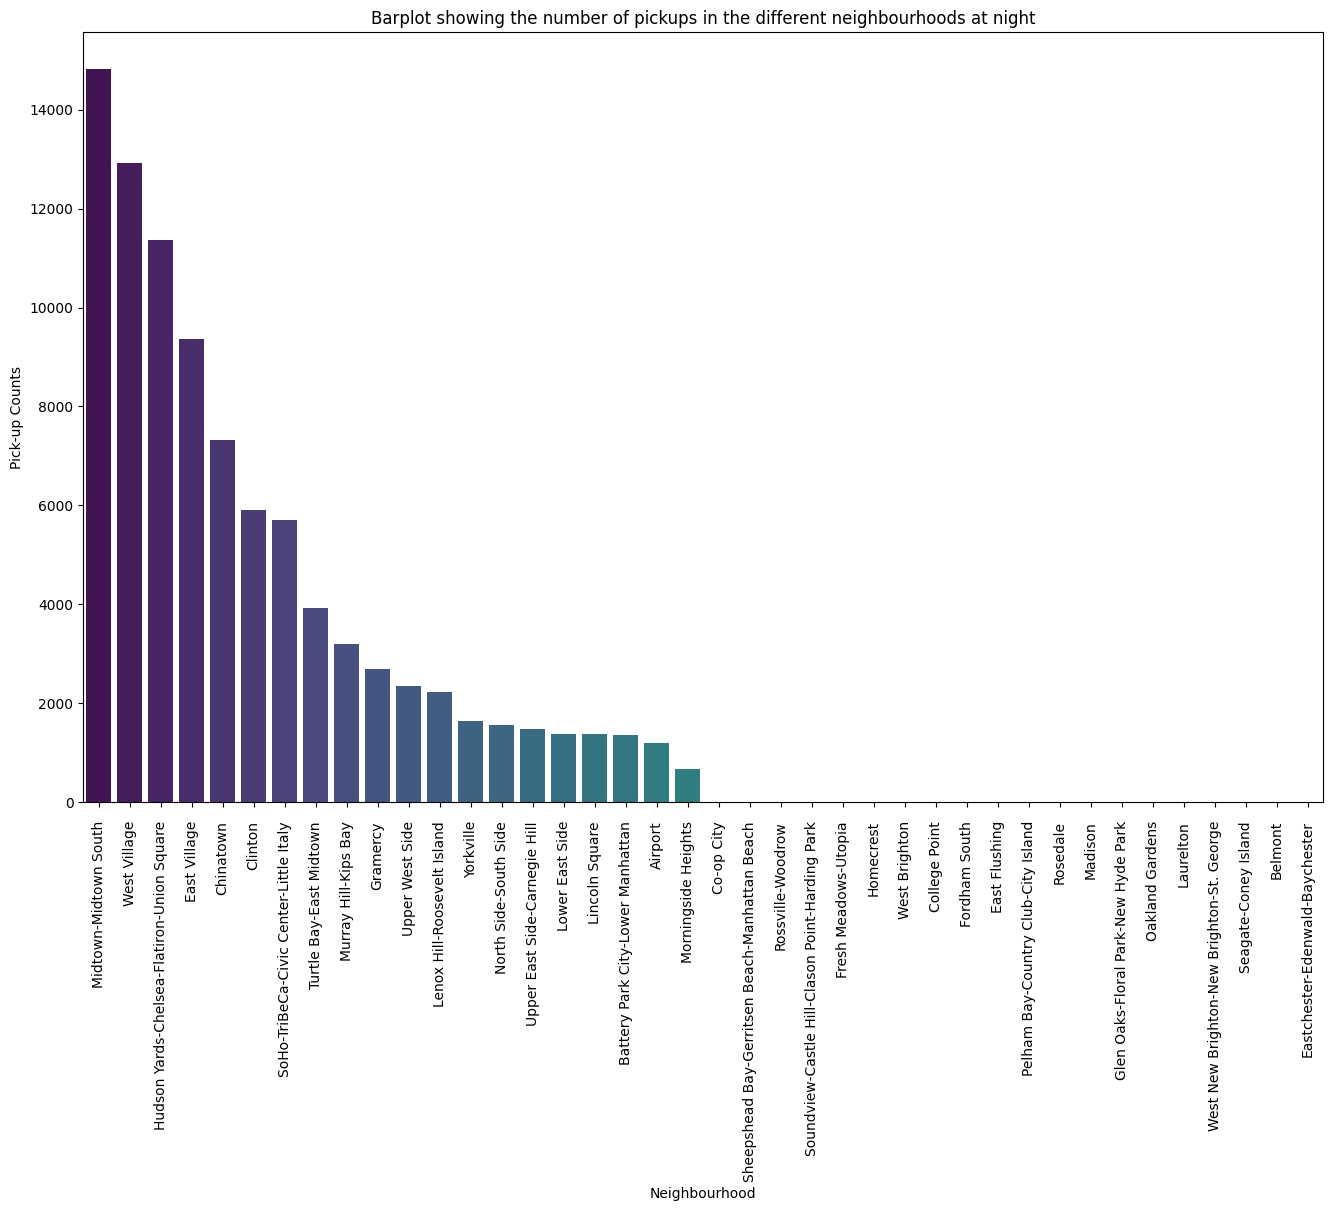

<Figure size 640x480 with 0 Axes>

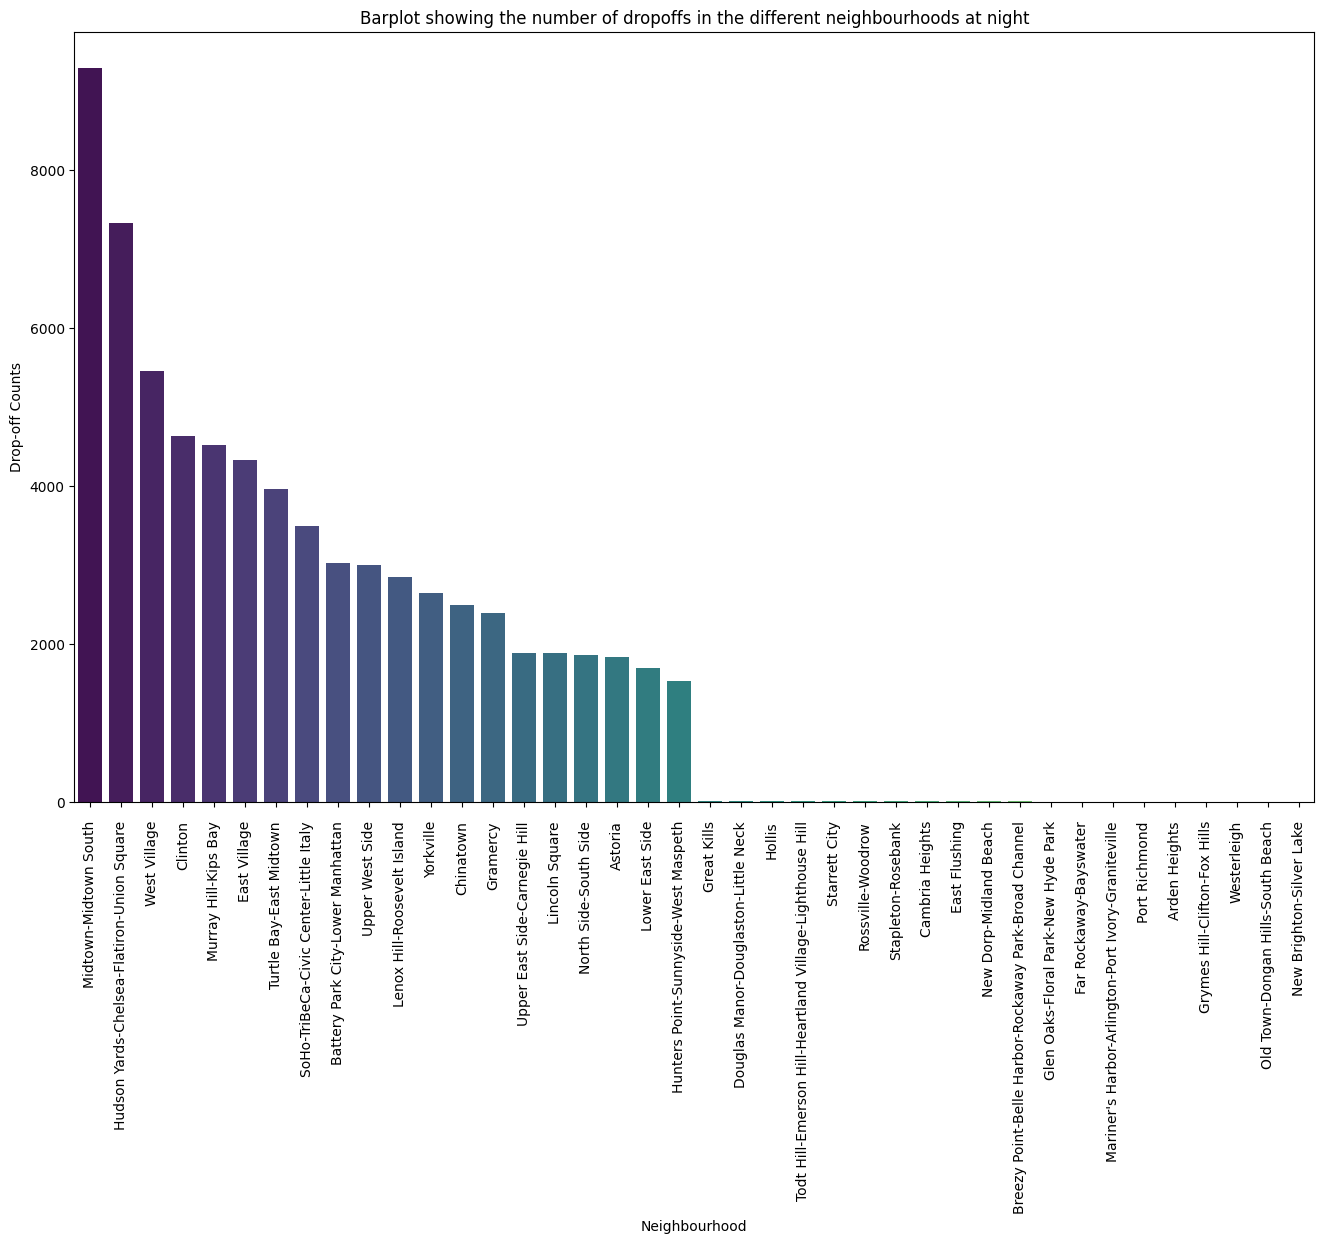

<Figure size 640x480 with 0 Axes>

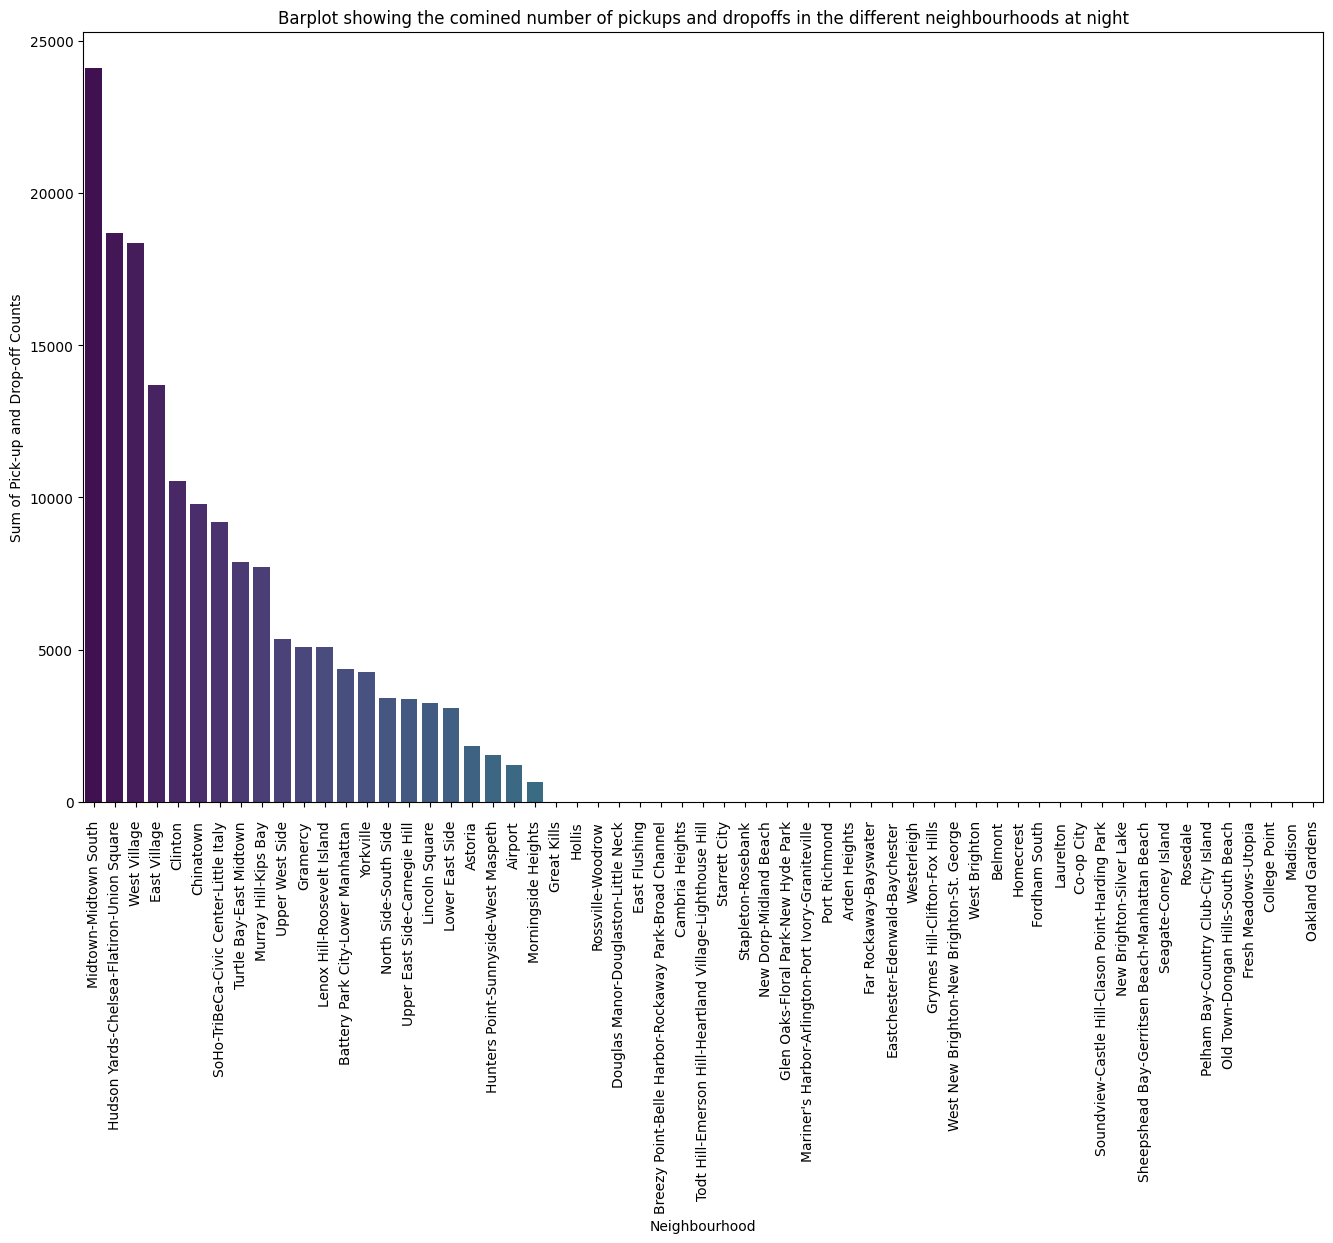

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(16, 10))
barplot = sns.barplot(pickup_night_trips_neighbourhood_counts, palette='viridis')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90,
                        horizontalalignment='center', fontsize=10)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.xlabel('Neighbourhood')
plt.ylabel('Pick-up Counts')
plt.title('Barplot showing the number of pickups in the different neighbourhoods at night')
plt.savefig('./Plots/Plots[6]/num_pickups_per_neighbourhood_at_night.png')
plt.show()
plt.clf()

plt.figure(figsize=(16, 10))
barplot = sns.barplot(dropoff_night_trips_neighbourhood_counts.head(100), palette='viridis')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90,
                        horizontalalignment='center', fontsize=10)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.xlabel('Neighbourhood')
plt.ylabel('Drop-off Counts')
plt.title('Barplot showing the number of dropoffs in the different neighbourhoods at night')
plt.savefig('./Plots/Plots[6]/num_dropoffs_per_neighbourhood_at_night.png')
plt.show()
plt.clf()

plt.figure(figsize=(16, 10))
barplot = sns.barplot(total_activity_night_trips_neighbourhood_counts, palette='viridis')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90,
                        horizontalalignment='center', fontsize=10)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.xlabel('Neighbourhood')
plt.ylabel('Sum of Pick-up and Drop-off Counts')
plt.title('Barplot showing the comined number of pickups and dropoffs in the different neighbourhoods at night')
plt.savefig('./Plots/Plots[6]/combined_num_pickups_dropoffs_per_neighbourhood_at_night.png')
plt.show()
plt.clf()